## 使用VGG-16模型进行风格转移

介绍
我们可以最大化神经网络中的特征激活，从而放大输入图像中的图案。这叫做DeepDreaming。

这个程序本使用类似的想法，但需要两个图像作为输入：内容图像和风格图像。然后，我们希望创建一个混合图像，该图像具有内容图像的轮廓以及样式图像的颜色和纹理。

### 第0步 - 我们在这里做什么？

德国研究人员在2015年的基本想法是重新设计一个训练有素的卷积网络来帮助转换两幅图像之间的风格。
我们将顶层用于分类，然后进行分割
使用给定层的特征向量来最小化两幅图像之间的差异

tensorflow 1.8，python 3.6，numpy和matplotlib

### 第1步 - 显示图片和视频的样式传输示例

视频风格转换纸http://genekogan.com/works/style-transfer/
引入了另一个损失函数来最小化光流
光流是由观察者和场景之间的相对运动引起的视觉场景中物体，表面和边缘的明显运动的模式
在底部显示视频风格转换和渐变vidoe

神经涂鸦建立在此https://github.com/alexjc/neural-doodle使用图像分割创建语义地图

### 第2步 - 这个过程是什么？

我们想要从内容图像中选择多行
我们希望和风格图像的纹理
什么是过滤器？ https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/
每个conv层都有我们设置的3D滤镜。可能是1.可能是20。
通常用于识别特征是否存在分类
即使标记图像和特征图输出之间的损失最小化
每个过滤器都对输入进行操作
输出3D功能地图/激活地图。
从混合图像的随机噪声开始
计算不同层次的不同损失函数
权衡这些损失函数分别
组合损失函数的梯度来更新混合图像
我们做这100-1000次，直到图像混合

### 内容丢失

计算更高层的特征/值
尽量减少内容和混合图像之间的激活功能之间的差异。计算均方误差。那就是亏损功能。我们想尽量减少这一点。
我们从内容图像缓存功能，因为我们不需要重新计算。

### 风格损失

多层
对于样式和混合图像，层1和层2的矩阵之间的差异最小化

## 流程图

该流程图大致显示了Style Transfer算法的思想，尽管我们使用的VGG-16模型比这里显示的层数多得多。

两幅图像输入到神经网络：内容图像和风格图像。我们希望生成具有内容图像的轮廓和样式图像的颜色和纹理的混合图像。
我们通过创建几个可以优化的损失函数来做到这一点。

内容图像的丢失功能会尝试最小化网络中一个或多个图层上为内容图像和混合图像激活的要素之间的差异。这导致混合图像的轮廓类似于内容图像的轮廓。

样式图像的损失函数稍微复杂一点，因为它试图最小化样式图像和混合图像的所谓格拉姆矩阵之间的差异。这是在网络中的一个或多个层完成的。格拉姆矩阵测量哪些特征在给定层中同时被激活。更改混合图像以便模仿样式图像的激活模式会导致颜色和纹理被传输。

我们使用TensorFlow自动导出这些损失函数的梯度。然后使用渐变来更新混合图像。该过程重复多次，直到我们对所得图像满意为止。

样式转移算法的一些细节未在此流程图中示出，例如关于格拉姆矩阵的计算，效率中间值的计算和存储，用于对混合图像进行去噪的损失函数，以及损失函数的归一化，使得它们相对于彼此更容易缩放。

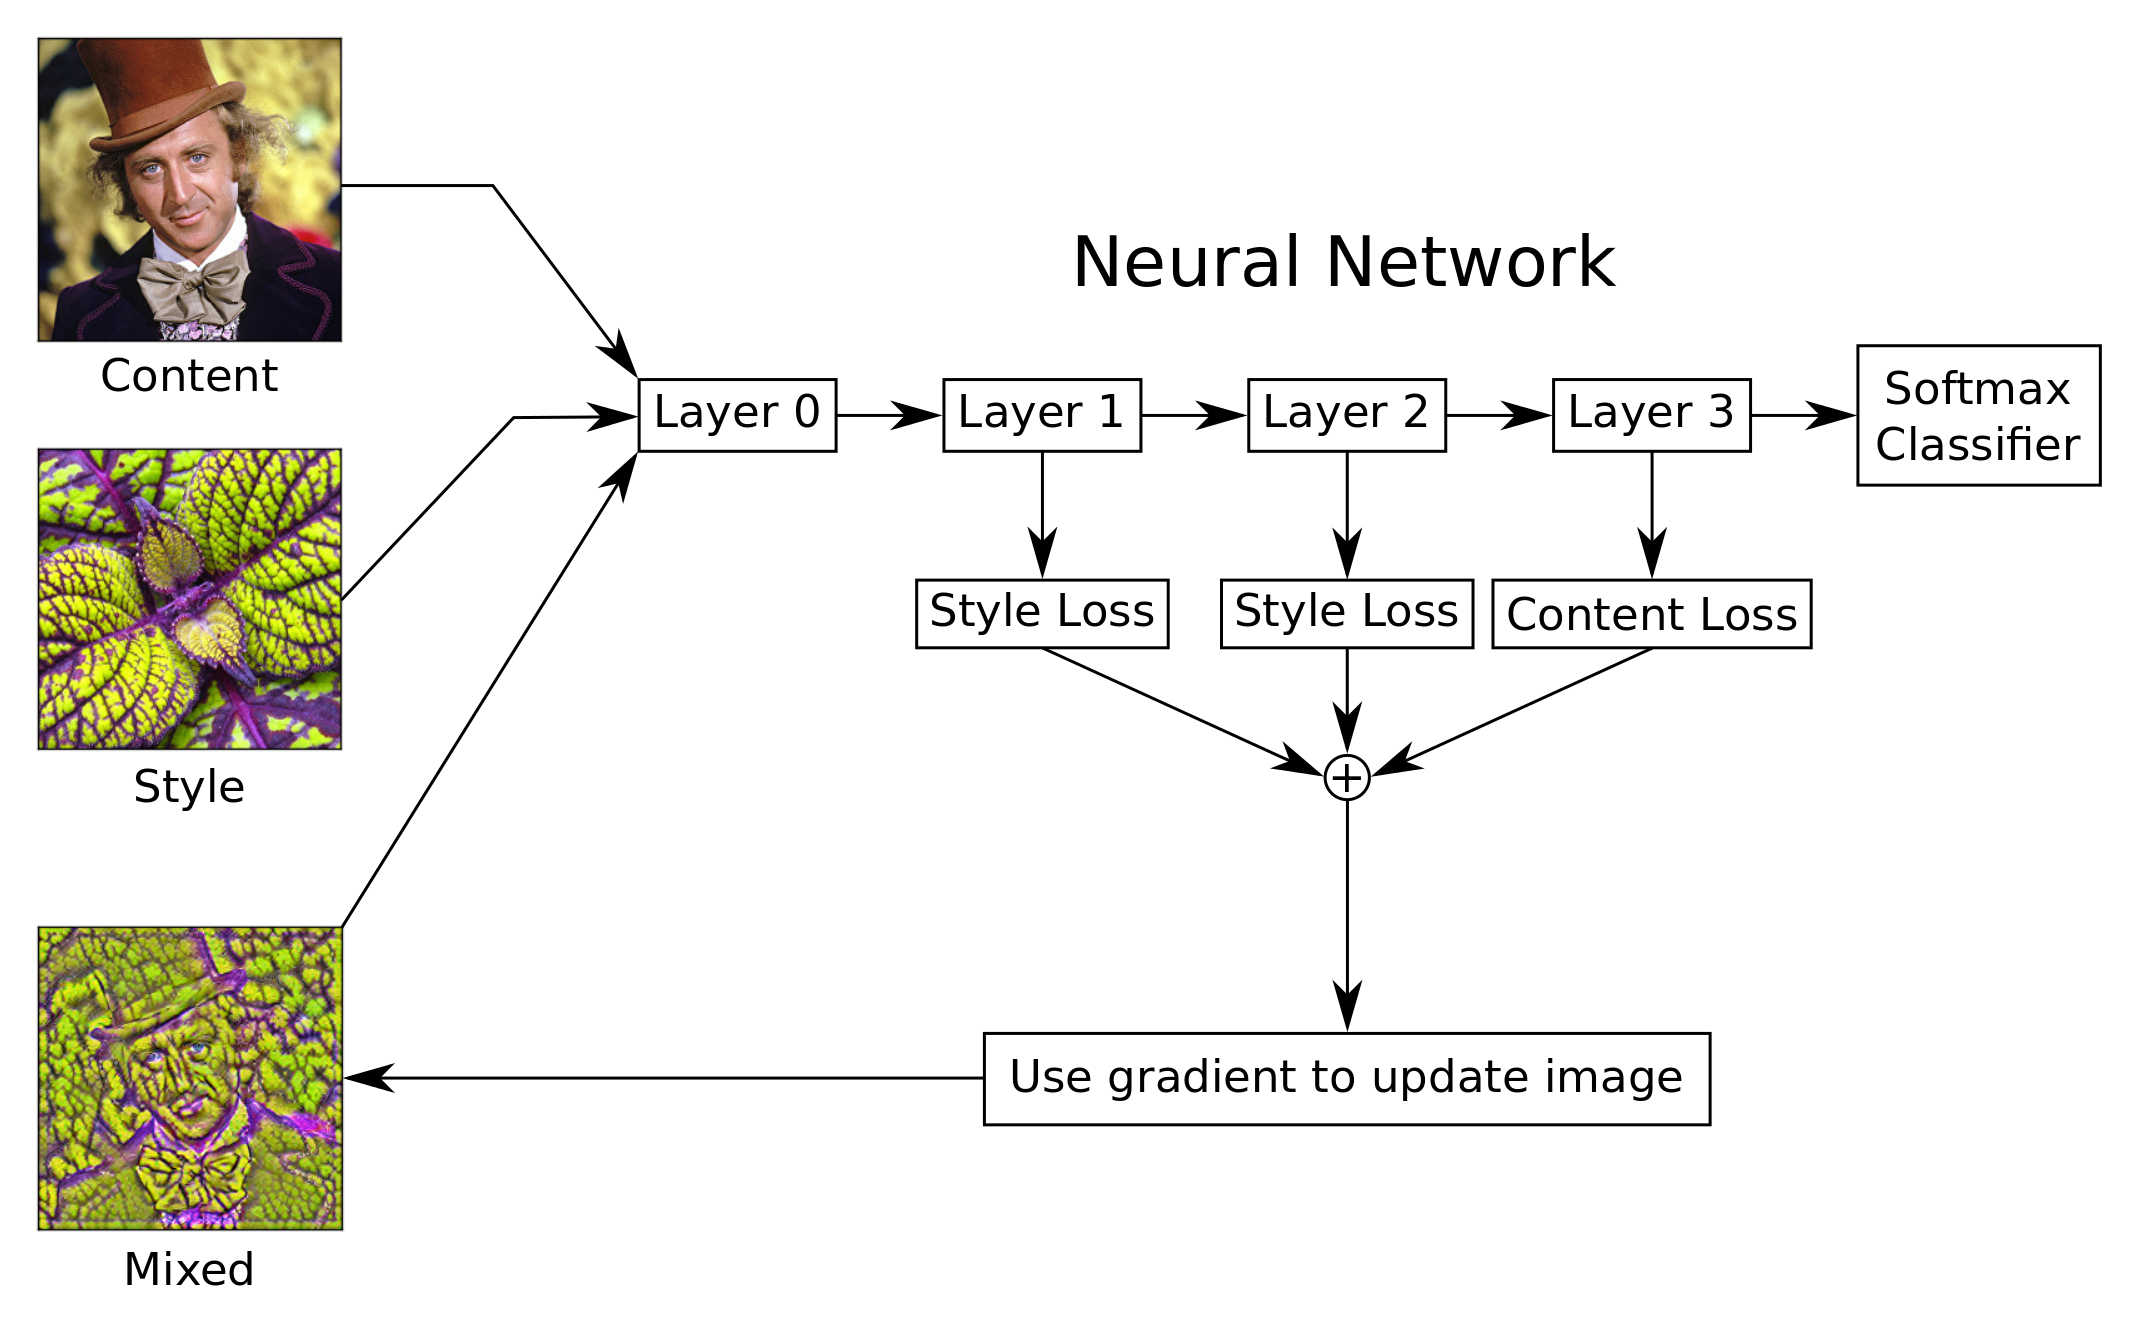

In [1]:
from IPython.display import Image, display

image_path = "./images/15_style_transfer_flowchart.png"
display(Image( filename = image_path))

引用

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

D:\Anaconda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


这是使用Python 3.6.3（Anaconda）和TensorFlow版本开发的：

In [3]:
tf.__version__

'1.8.0'

### VGG-16型号
花了两天的时间试图让样式转换算法与我们在Tutorial＃14中用于DeepDreaming的Inception 5h模型一起工作后，我无法生成看起来不错的图像。 这看起来很奇怪，因为在Tutorial＃14中生成的图像看起来相当不错。 但请记住，我们还使用了一些技巧来实现该质量，例如平滑渐变和递归缩放和处理图像。

最初的风格转移论文使用了VGG-19卷积神经网络。 但是，针对TensorFlow的预训练VGG-19模型由于各种原因似乎不适合本教程。 相反，我们将使用VGG-16模型，其他人已经提供并且可以很容易地在TensorFlow中加载。 为了方便起见，我们将其包装在一个类中。

In [4]:
import vgg16

VGG-16型号从互联网下载。 这是您要保存数据文件的默认目录。 如果该目录不存在，该目录将被创建。

In [5]:
# vgg16.data_dir = 'vgg16/'

如果目录中尚不存在VGG-16型号的数据，请下载它们。

警告：它是550 MB！

In [6]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


### 辅助函数用于图像处理

该函数加载图像并将其作为浮点数组返回。 图像可以自动调整大小，因此最大的高度或宽度等于max_size。

In [7]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # 计算合适的重新缩放因子
        # 确保最大高度和宽度，同时保持
        # 它们之间的比例。
        factor = max_size / np.max(image.size)
    
        # 缩放图像的高度和宽度。
        size = np.array(image.size) * factor

        # 这个大小现在是浮点，因为它是缩放的。
        # 但是，PIL要求大小是整数。        
        size = size.astype(int)

        # 调整图像大小。
        image = image.resize(size, PIL.Image.LANCZOS)

    # 转换为NUMPY浮点数组。
    return np.float32(image)

将图像保存为jpeg文件。 图像是以像素值在0到255之间的numpy数组形式给出的。

In [8]:
def save_image(image, filename):
    # 确保像素值介于0和255之间。
    image = np.clip(image, 0.0, 255.0)
    
    # 转换为字节。
    image = image.astype(np.uint8)
    
    # 用JPEG格式编写图像文件。
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

这个功能绘制一个大的图像。 图像是以像素值在0到255之间的numpy数组形式给出的。

In [9]:
def plot_image_big(image):
    # 确保像素值介于0和255之间。
    image = np.clip(image, 0.0, 255.0)

    # 将像素转换为字节。
    image = image.astype(np.uint8)

    # 转换为一个PIL图像并显示它。
    display(PIL.Image.fromarray(image))

此功能绘制内容，混合和样式图像。

In [10]:
def plot_images(content_image, style_image, mixed_image):
    # 用子图创建图形。
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # 调整垂直间距。
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # 使用插值平滑像素？
    smooth = True
    
    # 插值类型。
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # 绘制内容图像。
    # 注意像素值被归一化到
    # [1，0，1 ]范围除以255。
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # 绘制混合图像。
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # 绘制风格图像
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # 删除所有地块中的蜱虫。
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        
    #确保情节显示正确与多个情节
    #在单个Notebook单元中。
    plt.show()

### 损失函数

这些辅助函数创建用于使用TensorFlow进行优化的损失函数。

该函数创建TensorFlow操作来计算两个输入张量之间的均方误差。

In [11]:
# 平方的错误的平均数。
# 在给定图层的两个图像的输出值之间
# 平均误差越小，越接近寻找最佳拟合线。
# 平方米输出功能地图/激活地图之间的差异
# 并且通过将所有这些值加上然后除以n来平均所有这些值
# https://www.tensorflow.org/api_docs/python/tf/reduce_mean
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

此功能为内容图像创建丢失功能。 它是模型中给定图层中特征激活的均方误差，即内容图像和混合图像之间的特征激活。 当这种内容损失最小化时，它意味着混合图像在给定图层中具有与内容图像的激活非常相似的特征激活。 根据您选择的图层，这应该将轮廓从内容图像传输到混合图像。

In [12]:
# 第3步 - 内容图像是3D numpy数组，图层的索引
# 我们想用于内容丢失
# 你应该证明什么看起来不错的层次
# 没有最好的一层，我们还没有找到一种最小化的方法
# 失去美感。如何量化？
def create_content_loss(session, model, content_image, layer_ids):
    """
    为内容图像创建丢失功能。

    参数：
    session：用于运行模型图的开放式TensorFlow会话。
    model：模型，例如VGG16级别的一个实例。
    content_image：具有内容图像的Numpy浮点数组。
    layer_ids：要在模型中使用的图层的整数ID列表。
    """

    # 用python生成一个python字典对象
    # 占位符作为键和代表性提要
    # tensors作为值。
    # 用content-image创建一个feed-dict。    
    feed_dict = model.create_feed_dict(image=content_image)

    # 获取给定图层张量的参考。
    # 过滤器集合
    layers = model.get_layer_tensors(layer_ids)

    # 计算这些图层的输出值
    # 将内容图像提供给模型。
    values = session.run(layers, feed_dict=feed_dict)

    # 将模型的图形设置为默认值，以便我们可以添加
    # 计算节点。这并不总是很清楚
    # 在TensorFlow中这是必要的，但如果你
    # 想要重新使用此代码，那么它可能是必要的。
    with model.graph.as_default():
        # 初始化一个空的丢失函数列表。
        # 因为我们正在计算每层的损失
        layer_losses = []
    
        # 对于每个图层及其相应的值
        # 表示内容图像。
        for value, layer in zip(values, layers):
            # 表示内容图像。
            # 输入时在模型中为此图层添加
            # 内容图片。把它包起来以确保它
            # 是一个常量 - 虽然这可能会完成
            # 由TensorFlow自动完成。
            value_const = tf.constant(value)

            # 这个层的损失函数是
            # 图层值之间的均值平方误差
            # 输入内容和混合图像时。
            # 请注意，混合图像不计算
            # 但是，我们只是在创建这些操作
            # 用于计算这两者之间的MSE。
            loss = mean_squared_error(layer, value_const)

            # 将此图层的损失函数添加到
            # 损失函数列表。
            layer_losses.append(loss)

        # 所有图层的综合损失只是平均值。
        # 每层损失函数的权重可以不同。
        # 你可以试试看看会发生什么。
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

我们将为样式图层执行类似的操作，但现在我们要测量样式图层中的哪些要素同时为样式图像激活，然后将此激活样式复制到混合图像。

做这件事的一种方法是计算由样式层输出的张量的所谓的克拉矩阵。格拉姆矩阵本质上只是用于样式层特征激活向量的点积的矩阵。

如果格拉姆矩阵中的条目的值接近零，则表示给定图层中的两个特征不会同时激活给定的样式图像。反之亦然，如果格拉姆矩阵中的条目具有较大的值，那么这意味着两个特征对于给定的样式图像同时激活。然后，我们将尝试创建一个复制样式图像激活模式的混合图像。

这是用于计算神经网络中卷积层张量输出的克拉矩阵的辅助函数。实际的损失函数在下面进一步创建。

In [13]:
# 格式矩阵，定义为https://i.stack.imgur.com/tU9ow.png
# 已经习惯了
# 在平坦化之后衡量频道之间的相关性
# 将图片过滤到矢量中

# Gatys当被问及为什么在谈话中克矩阵是
# Gram矩阵编码秒
# 排序过滤器集的统计信息。
# 对某一特定图层的所有特征进行调整，
# 把空间信息转换成有利于度量的
# how不同的功能是相关的

def gram_matrix(tensor):
    # gram矩阵是向量的点积的向量样式图层的特征激活   
    # 来自卷积层的4d张量
    shape = tensor.get_shape()
    
    # 获取输入张量的特征通道数量，
    #被假定为来自卷积层的4-dim。
    num_channels = int(shape[3])

    # -1表示任何数字使数据适合
    # 重塑张量，使其成为2维矩阵。这基本上
    # 平整每个功能通道的内容。
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    
    # gram矩阵与其自身转置矩阵
    # 每个条目都以克矩阵表示
    # 如果某个功能频道存在倾向，则表示我们
    # 将被另一个功能通道激活
    
    # idea是从风格图像制作混合图像匹配模式
    
    
    # 计算格拉姆矩阵作为的矩阵乘积
    # 与它本身的2-dim矩阵。 这会计算出
    # 特征通道所有组合的点积。
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram   

下一个函数为样式图像创建丢失函数。 它与上面的create_content_loss（）非常相似，除了我们计算格拉姆矩阵的均方误差而不是来自图层的原始张量输出。

In [14]:
def create_style_loss(session, model, style_image, layer_ids):
    """
    创建样式图像的丢失函数。
    
    参数：
    session：用于运行模型图的开放式TensorFlow会话。
    模型：模型，例如 VGG16级别的一个实例。
    style_image：使用样式图像的Numpy浮点数组。
    layer_ids：要在模型中使用的图层的整数ID列表。
    """

    # 用样式图像创建一个feed-dict。
    feed_dict = model.create_feed_dict(image=style_image)

    # 获取给定图层张量的参考。
    layers = model.get_layer_tensors(layer_ids)


    """
    将模型的图形设置为默认值，
    以便我们可以向其添加计算节点。
    当在TensorFlow中这是必要的时候并不总是很清楚，
    但是如果你想重新使用这个代码，那么它可能是必要的。
    """
    with model.graph.as_default():
        # 构建TensorFlow操作进行计算
        # 每个图层的格拉姆矩阵。
        gram_layers = [gram_matrix(layer) for layer in layers]

        # 计算这些格拉姆矩阵的值时
        # 将样式图像提供给模型。
        values = session.run(gram_layers, feed_dict=feed_dict)

        # 初始化一个空的亏损函数列表。
        layer_losses = []
    
        # 对于每个格拉姆矩阵图层及其相应的值。
        for value, gram_layer in zip(values, gram_layers):
            """ 
            这些是在输入样式图像时为模型中的此层计算的格拉姆矩阵值。
            将它包装以确保它是一个常量，虽然这可能由TensorFlow自动完成。
            """
            value_const = tf.constant(value)

            # 这个层的损失函数是
            # 克拉矩阵值之间的均方根误差
            # 用于内容和混合图像。
            # 请注意，混合图像不计算
            # 但是，我们只是在创建这些操作
            # 用于计算这两者之间的MSE。


            # 输入时克矩阵与克矩阵的值之间
            # 风格的图像

            loss = mean_squared_error(gram_layer, value_const)

            # 为此图层添加损失函数
            # 函数列表。
            layer_losses.append(loss)

        # 所有层面的综合损失只是平均值。 
        # 对于每一层，损失函数可以加权不同。
        # 你可以试试看看会发生什么。
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

这创建了对混合图像进行去噪的损失函数。 该算法被称为全变差去噪（Total Variation Denoising），基本上仅将图像在x轴和y轴上移动一个像素，计算与原始图像的差异，取绝对值以确保差异是正数，并且将所有 图像中的像素。 这产生了可以被最小化的损失函数，以便抑制图像中的一些噪声。

In [15]:
# 在x和y轴上将输入图像移动1个像素
# 计算移位图像和原始图像之间的差异
# 绝对值，以使正面计算这些图像中像素的总和
# 帮助抑制我们正在生成的混合图像中的噪点


def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

### 风格转移算法
这是Style-Transfer算法的主要优化算法。 它基本上只是上面定义的损失函数的梯度下降。

该算法还使用损失函数的归一化。 这似乎是一个以前没有发表过的新颖想法。 在优化的每次迭代中，损失值都会被调整，因此每个值都等于1。 这允许用户独立于所选择的样式和内容层来设置丢失权重。 它还调整优化期间的权重以确保风格，内容和去噪之间的期望比例得以保留。

In [17]:
# 相对权重 - 归一化。
# style应该比内容拥有更多的权重
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    """
    使用渐变下降来查找使图像最小化的图像
    内容层和样式层的损失函数。 这个
    应该会产生类似于轮廓的混合图像
    的内容图像，并且类似于颜色和纹理
    的风格形象。

    参数：
    content_image：含有内容图像的Numpy 3-dim浮点数组。
    style_image：使用样式图像的Numpy 3-dim浮点数组。
    content_layer_ids：识别内容层的整数列表。
    style_layer_ids：标识样式图层的整数列表。
    weight_content：内容丢失函数的权重。
    weight_style：样式丢失函数的权重。
    weight_denoise：去噪 - 损失函数的权重。
    num_iterations：要执行的优化迭代次数。
    step_size：每次迭代中梯度的步长。
    """

    # 创建VGG16模型的一个实例。 这个做完了
    # 在这个函数的每次调用中，因为我们会添加
    # 对图表的操作，所以它可以增长很大
    # 如果我们继续使用相同的实例，则会耗尽内存。
    model = vgg16.VGG16()

    # 创建一个TensorFlow会话。
    session = tf.InteractiveSession(graph=model.graph)

    # 打印内容层的名称。
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # 为内容层和-image创建丢失函数。
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # 为样式图层和图像创建丢失函数。
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # 创建混合图像去噪的损失函数。
    loss_denoise = create_denoise_loss(model)

    
    # 调整损失函数的水平，使其正常化
    #用变量乘以它们
    #提供内容，风格，去噪等损失值的倒数值
    #small常数以避免被0除
    #调整值使损失正常化大约1
    #weights应该相对于彼此设置不依赖于图层
    #我们正在使用
    
    # 创建TensorFlow变量以调整值
    # 损失函数。 这在下面解释。
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # 初始化损失函数的调整值。
    session.run([adj_content.initializer,
                 adj_style.initializer,    
                 adj_denoise.initializer])

    # 创建TensorFlow操作以更新调整值。
    # 这些基本上就是这些的互惠价值
    # 损失函数，添加一个小的值1e-10以避免
    # 被零除的可能性。
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # 这是我们将最小化的加权损失函数
    # 以便生成混合图像。
    # 因为我们将损失值与它们的倒数相乘
    # 调整值，我们可以使用相对权重
    #丢失功能更容易选择，因为它们是
    #独立于风格和内容层的确切选择。
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # 使用TensorFlow获取数学函数
    # 关于组合损失函数的梯度
    # 输入图像。（混合）
    gradient = tf.gradients(loss_combined, model.input)

    # 我们将在每次优化迭代中运行的张量列表。
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # 混合图像用随机噪声初始化。
    # 它与内容图像大小相同。
    # 我们首先启动它
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # 用混合图像创建一个feed-dict。
        feed_dict = model.create_feed_dict(image=mixed_image)

        # 使用TensorFlow来计算的值
        # 渐变，以及更新调整值。
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # 减少渐变的维度。
        # 从数组形状中删除单维条目。
        grad = np.squeeze(grad)

        # 根据梯度值缩放步长。
        # 权重比率：更新
        # 类似于学习率
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # 按照渐变更新图像。
        # 梯度下降
        mixed_image -= grad * step_size_scaled

        # 确保图像的有效像素值介于0和255之间。
        # 给定一个区间，区间外的值被剪切 
        # 到间隔边缘。
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # 打印一点进度指示器。
        print(". ", end="")

        # 每10次迭代显示一次状态，最后一次显示状态。
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # 为丢失功能打印调整权重。
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # 更大的分辨率
            # 绘制内容，风格和混合图像。
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # 关闭TensorFlow会话以释放其资源。
    session.close()
    
    # 返回混合图像。
    return mixed_image

### 例如:
此示例显示如何将各种图像的样式转换为肖像。

首先我们加载具有我们想要的混合图像中的整体轮廓的内容图像。

In [18]:
content_filename = 'images/hugo.jpg'
content_image = load_image(content_filename, max_size=None)

image_path_content = './images/hugo.jpg'
display(Image( filename = image_path_content))

然后我们加载具有我们想要的混合图像中的颜色和纹理的样式图像。

In [1]:
style_filename = 'images/style2.jpg'
style_image = load_image(style_filename, max_size=300)

image_path_style = './images/style2.jpg'
display(Image( filename = image_path_style))

NameError: name 'load_image' is not defined

然后我们定义一个整数列表，标识我们想用来匹配内容图像的神经网络中的图层。 这些是神经网络中各层的索引。 对于VGG16模型，第5层（索引4）似乎很适合作为唯一的内容层。

In [20]:
content_layer_ids = [4]

然后我们为样式层定义另一个整数列表。

In [21]:
# VGG16模型有13个卷积层。
# 这将选择所有这些图层作为样式图层。
# 这在优化方面有点慢。
style_layer_ids = list(range(13))

# 你也可以选择图层的一个子集，例如 喜欢这个：
# style_layer_ids = [1，2，3，4]

### 注意
1.内容图像和混合图像之间的损失最小化，

2.使风格图像与混合图像之间的损失最小化，

3.现在执行风格转移。 这会自动为样式层和内容层创建适当的损失函数，然后执行一些优化迭代。 

这将逐渐创建与内容图像具有相似轮廓的混合图像，其颜色和纹理与样式图像相似。

如果使用GPU可能非常快！

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 1.28e-10, Style: 4.78e-29, Denoise: 1.91e-06


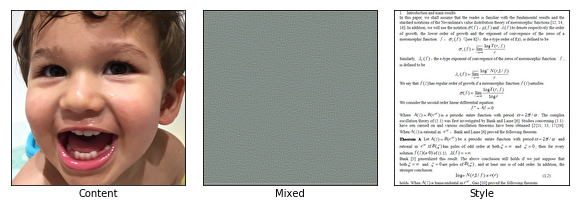

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 6.97e-11, Style: 2.44e-28, Denoise: 6.08e-08


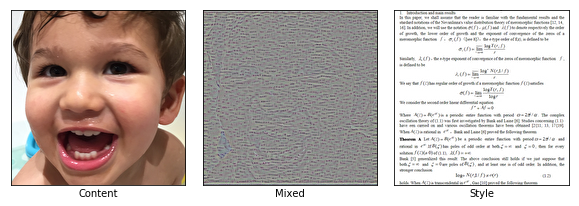

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 6.97e-11, Style: 2.88e-28, Denoise: 6.02e-08


. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 6.96e-11, Style: 3.17e-28, Denoise: 5.96e-08


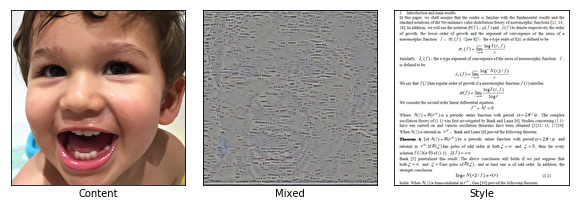

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 6.97e-11, Style: 3.56e-28, Denoise: 5.89e-08


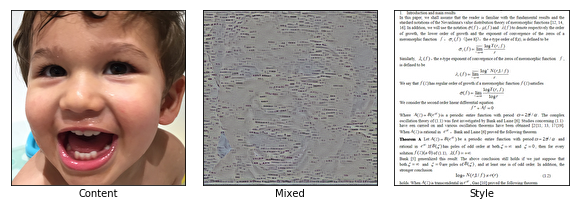

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 6.97e-11, Style: 3.71e-28, Denoise: 5.98e-08


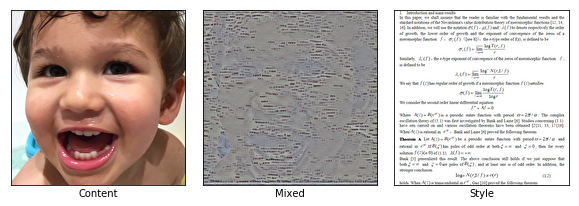

. . . . . . . . . . 
Iteration: 60
Weight Adj. for Content: 7.25e-11, Style: 3.92e-28, Denoise: 6.33e-08


. . . . . . . . . . 
Iteration: 70
Weight Adj. for Content: 6.79e-11, Style: 3.36e-28, Denoise: 6.01e-08


. . . . . . . . . . 
Iteration: 80
Weight Adj. for Content: 6.81e-11, Style: 3.91e-28, Denoise: 5.98e-08


. . . . . . . . . . 
Iteration: 90
Weight Adj. for Content: 6.90e-11, Style: 3.79e-28, Denoise: 5.94e-08


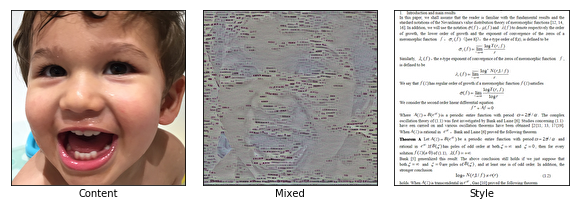

. . . . . . . . . . 
Iteration: 100
Weight Adj. for Content: 6.75e-11, Style: 2.95e-28, Denoise: 7.06e-08


. . . . . . . . . . 
Iteration: 110
Weight Adj. for Content: 6.81e-11, Style: 3.22e-28, Denoise: 6.23e-08


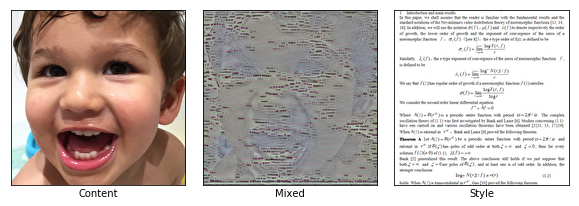

. . . . . . . . . . 
Iteration: 120
Weight Adj. for Content: 6.95e-11, Style: 5.54e-28, Denoise: 6.06e-08


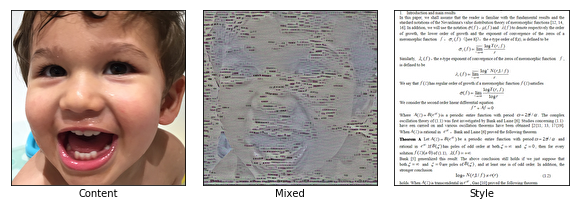

. . . . . . . . . . 
Iteration: 130
Weight Adj. for Content: 6.78e-11, Style: 2.77e-28, Denoise: 6.64e-08


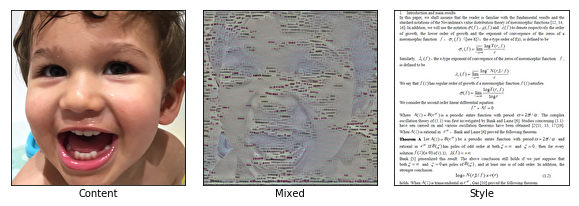

. . . . . . . . . . 
Iteration: 140
Weight Adj. for Content: 5.75e-11, Style: 2.91e-28, Denoise: 5.27e-08


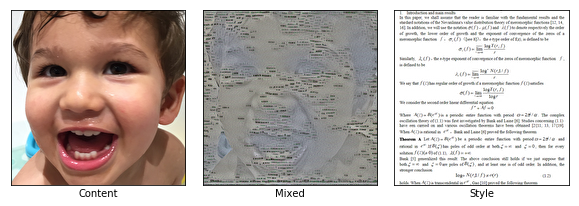

. . . . . . . . . . 
Iteration: 150
Weight Adj. for Content: 6.07e-11, Style: 3.18e-28, Denoise: 5.29e-08


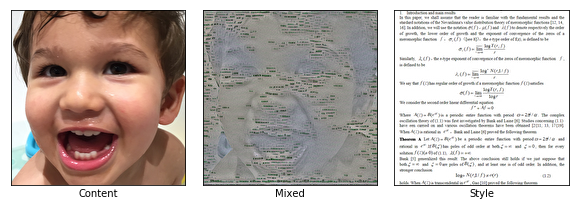

. . . . . . . . . . 
Iteration: 160
Weight Adj. for Content: 5.78e-11, Style: 2.00e-28, Denoise: 5.24e-08


. . . . . . . . . . 
Iteration: 170
Weight Adj. for Content: 5.41e-11, Style: 3.46e-28, Denoise: 6.12e-08


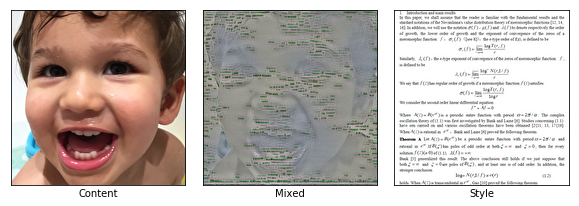

. . . . . . . . . . 
Iteration: 180
Weight Adj. for Content: 5.75e-11, Style: 1.84e-28, Denoise: 5.43e-08


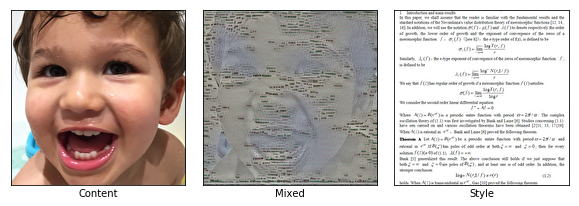

. . . . . . . . . . 
Iteration: 190
Weight Adj. for Content: 6.85e-11, Style: 5.59e-28, Denoise: 5.94e-08


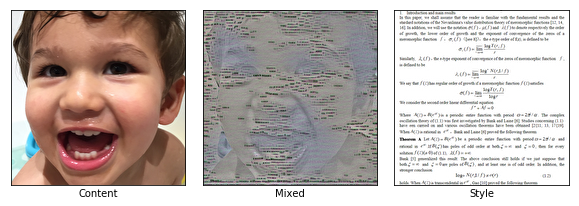

. . . . . . . . . 
Iteration: 199
Weight Adj. for Content: 5.83e-11, Style: 3.69e-28, Denoise: 5.75e-08


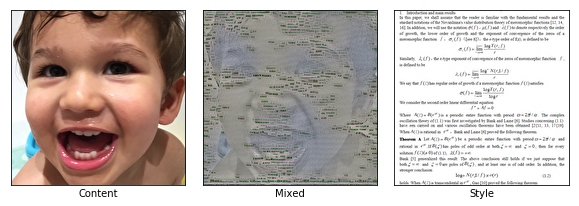


Final image:


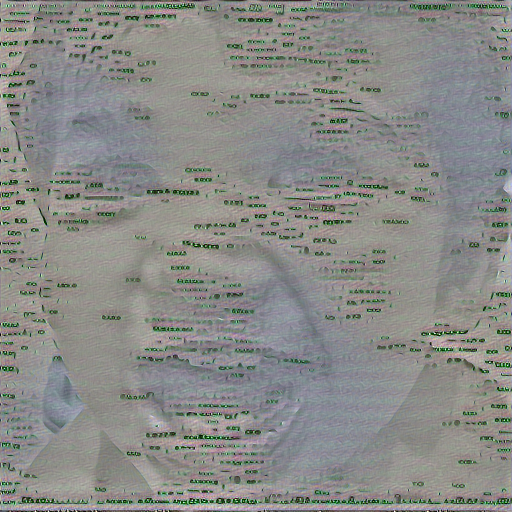

Wall time: 22min 11s


In [22]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=8.0,
                     weight_denoise=0.3,
                     num_iterations=200,
                     step_size=10.0)

参考：
VGG 16型号：https：//github.com/pkmital/CADL/blob/master/session-4/libs/vgg16.py

大部分代码来自TensorFlow-Tutorials。 我强烈推荐给那些想要开始使用TensorFlow的人。

In [ ]:
# %%time
# img = style_transfer(content_image=content_image,
#                      style_image=style_image,
#                      content_layer_ids=content_layer_ids,
#                      style_layer_ids=style_layer_ids,
#                      weight_content=1.5,
#                      weight_style=10.0,
#                      weight_denoise=0.3,
#                      num_iterations=60,
#                      step_size=10.0)